In [1]:
from typing import Any
import numpy as np
from numpy import linalg as la

import sys
EPS = sys.float_info.epsilon * 2

def exact(x): # No change
    var = 0
    bits = x.dtype.itemsize * 8 * x.size
    
    return x, bits, var

def signum(x): # For sign_GD
    code = np.sign(x)
    var = (la.norm(x - code) / la.norm(x))**2
    bits = int(x.size)
    
    return np.sign(x), bits, var

def tern_biased(aa, compute_var=True):
    a = aa.copy()
    L = np.max(np.abs(a))
    a[a > L/2] = L
    a[a < -L/2] = -L
    a[np.abs(a) <= L/2] = 0
    
    bits = min(np.count_nonzero(a) * (1 + np.log2(a.size)), np.log2(3) * a.size)
    bits = int(np.ceil(bits)) + aa.dtype.itemsize * 8
    if compute_var:
        var = (la.norm(aa - a) / la.norm(aa))**2
    else:
        var = 0
    
    return a, bits, var

def tern_unbiased(aa, norm=np.inf, compute_var=True):
    a = aa.copy()
    a_norm = la.norm(a, ord=norm)
    prob = abs(a) / a_norm
    a = np.sign(a) * a_norm * np.random.binomial(1, prob)
    
    bits = min(np.count_nonzero(a) * (1 + np.log2(a.size)), np.log2(3) * a.size)
    bits = int(np.ceil(bits)) + aa.dtype.itemsize * 8
    
    if compute_var:
        var = (la.norm(aa - a) / la.norm(aa))**2
    else:
        var = 0
    
    return a, bits, var

def random_sparsification(x, q=0.05): # q - fraction of nonzero elements
    d = x.size
    
    mask = np.ones(d)
    n_zeros = int(np.ceil(d * (1 - q)))
    positions = np.random.choice(d, n_zeros, replace=False)
    mask[positions] = 0
    code = mask * x # * d / q

    bits = (x.dtype.itemsize * 8) * (d - n_zeros)
    bits = int(np.ceil(bits))
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, bits, var


def top_k(x, q=0.05): # q - fraction of nonzero elements
    d = x.size
    k = int(np.ceil(d * q))
    
    mask = np.ones(d)
    
    n_zeros = int(np.ceil(d * (1 - q)))
    positions = np.argpartition(np.abs(x), -k)[:-k]
    mask[positions] = 0
    code = mask * x # * d / q

    bits = (x.dtype.itemsize * 8) * (d - n_zeros)
    bits = int(np.ceil(bits))
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, bits, var


def natural_compression(x):
    y = np.abs(x) #/ la.norm(x)
    denominator = 2**np.floor(np.log2(y))
    p = np.maximum((2**np.ceil(np.log2(y)) - y) / denominator, 0) #np.floor(np.log2(y))
    code = np.sign(x) * denominator * (1 + np.random.binomial(1, 1 - p))
    
    if x.dtype.itemsize == 8:
        bits = 12 * x.size
    else:
        bits = 9 * x.size
    
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, bits, var


def natural_dithering(x, s=10, norm=None, compr_norm=True):
    bits = x.size * (2 + np.log2(s)) # (2 + s)
    bits = int(np.ceil(bits))
        
    norm_x = la.norm(x, norm)
    if norm_x < EPS:
        return np.zeros_like(x), bits, 0
    
    y = np.abs(x) / norm_x
    for k in range(y.size): # I guess it is possible to vectorize it.
        if y[k] < EPS:
            y[k] = 0
        else:
            i = int(np.floor(np.log2(y[k]) + s))

            if i <= 0:
                left_lvl = 0
                right_lvl = 2**(1-s)
            else:
                left_lvl = 2**(i-s)
                right_lvl = 2**(i+1-s)

            prob = (right_lvl - y[k]) / (right_lvl - left_lvl)
            y[k] = left_lvl if np.random.binomial(1, prob) else min(1, right_lvl) # xi
            
    if compr_norm:
        compressed_norm, _, _ = natural_compression(norm_x)
        if x.dtype.itemsize == 8:
            bits += 11
        else:
            bits += 8
    else:
        compressed_norm = norm_x
        bits += x.dtype.itemsize * 8
        
    code = compressed_norm * np.sign(x) * y    
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, bits, var

import torch
from eden import eden_builder

def eden(x, quant, n_bits, top: bool):
    code, _ = quant.roundtrip(x)

    var = (la.norm(x - code) / la.norm(x))**2
    bits = n_bits * len(x) + 4
    if n_bits < 1 and top:
        bits += min(
            n_bits * len(x) * np.log2(len(x)), # positions
            (1 - n_bits) * len(x) * np.log2(len(x)), # not positions
            len(x), # mask
        )
    return code, bits, var


from cocktailsgd import compress_nbits, decompress_nbits

def cocktail(x, rand_p=0.1, top_p=0.2, bits=4):
    rand_d = x.size
    
    # Rand K
    n_zeros = int(np.ceil(rand_d * (1 - rand_p)))
    positions = np.random.choice(rand_d, n_zeros, replace=False)

    mask = np.ones(rand_d)
    mask[positions] = 0
    code = mask * x # * d / q
    
    # Top K 
    top_d = rand_d - n_zeros
    k = int(np.ceil(top_d * top_p))
    positions = np.argpartition(np.abs(x), -k)[:-k]

    mask = np.ones(rand_d)
    mask[positions] = 0
    code = mask * code # * d / q

    # Quant
    code = decompress_nbits(*compress_nbits(torch.tensor(code), bits=bits, scale_dims=(0,)), bits=bits).numpy()

    # Bits
    total_bits = bits * k + np.log2(top_d) * k
    total_bits = int(np.ceil(total_bits))
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, total_bits, var

In [2]:
sparse_variances = []
sparse_bits = []
for q in np.linspace(0.0001, 0.30, num=100):
    for i in range(3):
        _, bit, var = random_sparsification(np.random.normal(size=(1000,)).astype(np.float32), q=q)
        sparse_variances.append(var)
        sparse_bits.append(bit / 1000)

In [3]:
top_variances = []
top_bits = []
for q in np.linspace(0.0001, 0.30, num=100):
    for i in range(3):
        _, bit, var = top_k(np.random.normal(size=(1000,)).astype(np.float32), q=q)
        top_variances.append(var)
        top_bits.append(bit / 1000)

In [4]:
nat_dith_variances = []
nat_dith_bits = []
for s in range(2, 20):
    for i in range(3):
        _, bit, var = natural_dithering(np.random.normal(size=(1000,)).astype(np.float32), s=s)
        nat_dith_variances.append(var)
        nat_dith_bits.append(bit / 1000)

In [5]:
nat_comp_variances = []
nat_comp_bits = []
for i in range(10):
    _, bit, var = natural_compression(np.random.normal(size=(1000,)).astype(np.float32))
    nat_comp_variances.append(var)
    nat_comp_bits.append(bit / 1000)

In [21]:
eden_rand_variances = []
eden_rand_bits = []
for n_bits in np.linspace(0.05, 7.9, num=100):
    quant = eden_builder(bits=n_bits, top=False)
    for i in range(3):
        _, bit, var = eden(torch.empty(1000).normal_(0,1), quant, n_bits=n_bits, top=False)
        eden_rand_variances.append(var)
        eden_rand_bits.append(bit / 1000)

In [39]:
eden_top_variances = []
eden_top_bits = []
for n_bits in np.linspace(0.01, 0.999, num=100):
    quant = eden_builder(bits=n_bits, top=True)
    for i in range(3):
        _, bit, var = eden(torch.empty(1000).normal_(0,1), quant, n_bits=n_bits, top=True)
        eden_top_variances.append(var)
        eden_top_bits.append(bit / 1000)

In [40]:
cock_variances = []
cock_bits = []

for rand_p in np.linspace(0.1, 1, num=9):
    for top_p in np.linspace(0.2, 0.2, num=9):
        for i in range(3):
            _, bit, var = cocktail(np.random.normal(size=(1000,)).astype(np.float32), rand_p=rand_p, top_p=top_p)
            cock_variances.append(var)
            cock_bits.append(bit / 1000)

In [41]:
import matplotlib.pyplot as plt


x = np.linspace(0, 9, num=100)
y = 4**(-x)

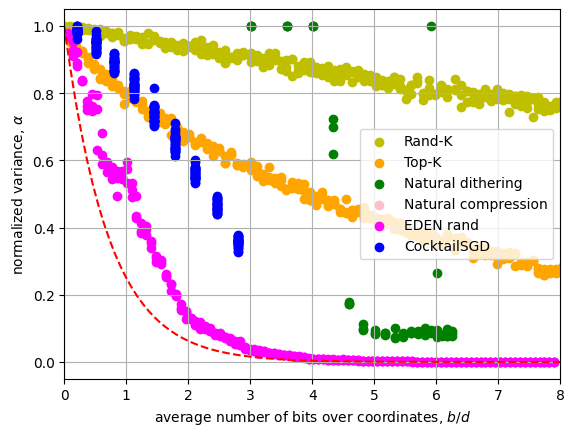

In [46]:
plt.scatter(sparse_bits, sparse_variances, color="y", label="Rand-K")
plt.scatter(top_bits, top_variances, color="orange", label="Top-K")
plt.scatter(nat_dith_bits, [min(val, 1) for val in nat_dith_variances], color="green", label="Natural dithering")
plt.scatter(nat_comp_bits, nat_comp_variances, color="pink", label="Natural compression")
plt.scatter(eden_rand_bits, eden_rand_variances, color="fuchsia", label="EDEN rand")
# plt.scatter(eden_top_bits, eden_top_variances, color="purple", label="EDEN top")
plt.scatter(cock_bits, cock_variances, color="blue", label="CocktailSGD")


plt.plot(x, y, linestyle="--", color="red")

plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))
plt.grid()
plt.xlabel(r"average number of bits over coordinates, $b/d$")
plt.ylabel(r"normalized variance, $\alpha$")
plt.legend()
plt.xlim(0, 8)
plt.show()